In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [241]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mahdimashayekhi/fake-news-detection-dataset")

Skipping, found downloaded files in "./fake-news-detection-dataset" (use force=True to force download)


In [242]:
df=pd.read_csv("/content/fake-news-detection-dataset/fake_news_dataset.csv")
df.head()

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake


In [243]:
# Show top 5 most common words in dataset using pandas
all_words = ' '.join(df['text']).split()
word_series = pd.Series(all_words)
top_words = word_series.value_counts().head(10)
print("Top 10 words:\n", top_words)

Top 10 words:
 else         5369
listen       5341
purpose      5339
wear         5338
summer       5323
thought      5320
child        5314
direction    5312
factor       5311
ability      5311
Name: count, dtype: int64


In [194]:
all_authors=list(df['author'].unique())
print(f"The total number of authors are {len(all_authors)}")

The total number of authors are 17052


In [195]:
all_categories=list(df['category'].unique())
print(f"The total number of categories are: {len(all_categories)}")

The total number of categories are: 7


In [196]:
all_categories

['Politics',
 'Business',
 'Science',
 'Technology',
 'Health',
 'Sports',
 'Entertainment']

In [197]:
df['category'].value_counts()

,count
category,
Health,2922
Entertainment,2889
Technology,2882
Sports,2867
Business,2849
Politics,2802
Science,2789


In [198]:
df.columns = df.columns.str.strip()  # remove leading/trailing spaces
print(df.columns)  # verify

Index(['title', 'text', 'date', 'source', 'author', 'category', 'label'], dtype='object')


In [199]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)
articles_per_day = df.groupby('date').size()
articles_per_day.head()

,0
date,
2022-04-26,22
2022-04-27,19
2022-04-28,15
2022-04-29,16
2022-04-30,20


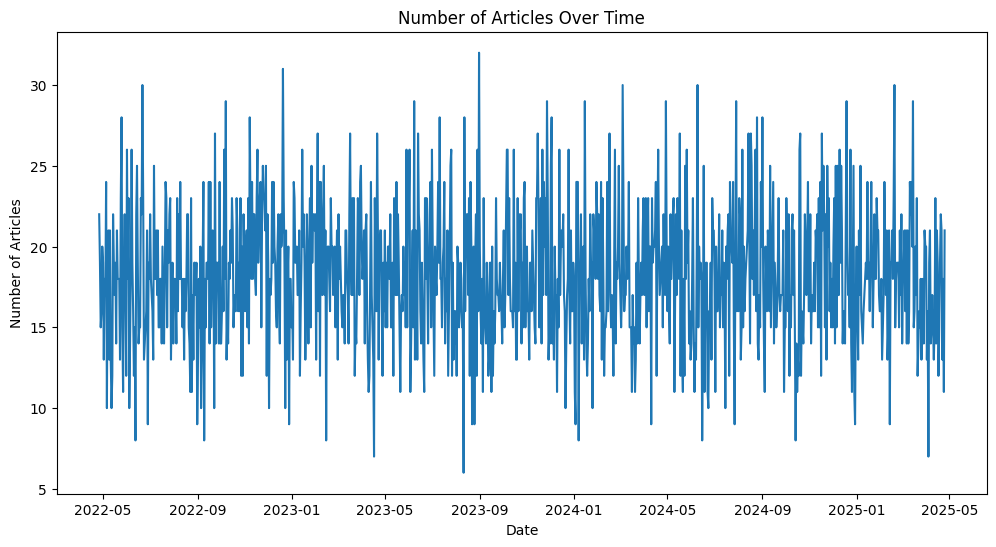

In [200]:
plt.figure(figsize=(12,6))
plt.plot(articles_per_day.index, articles_per_day.values)
plt.title("Number of Articles Over Time")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.show()

In [201]:
articles_by_label = df.groupby(['date','label']).size()
print(articles_by_label)
articles_by_label=articles_by_label.unstack(fill_value=0)
print(articles_by_label)


date        label
2022-04-26  fake      8
            real     14
2022-04-27  fake     10
            real      9
2022-04-28  fake      5
                     ..
2025-04-23  real      9
2025-04-24  fake      5
            real      6
2025-04-25  fake     13
            real      8
Length: 2192, dtype: int64
label       fake  real
date                  
2022-04-26     8    14
2022-04-27    10     9
2022-04-28     5    10
2022-04-29     6    10
2022-04-30    11     9
...          ...   ...
2025-04-21     7    14
2025-04-22     5     8
2025-04-23     9     9
2025-04-24     5     6
2025-04-25    13     8

[1096 rows x 2 columns]


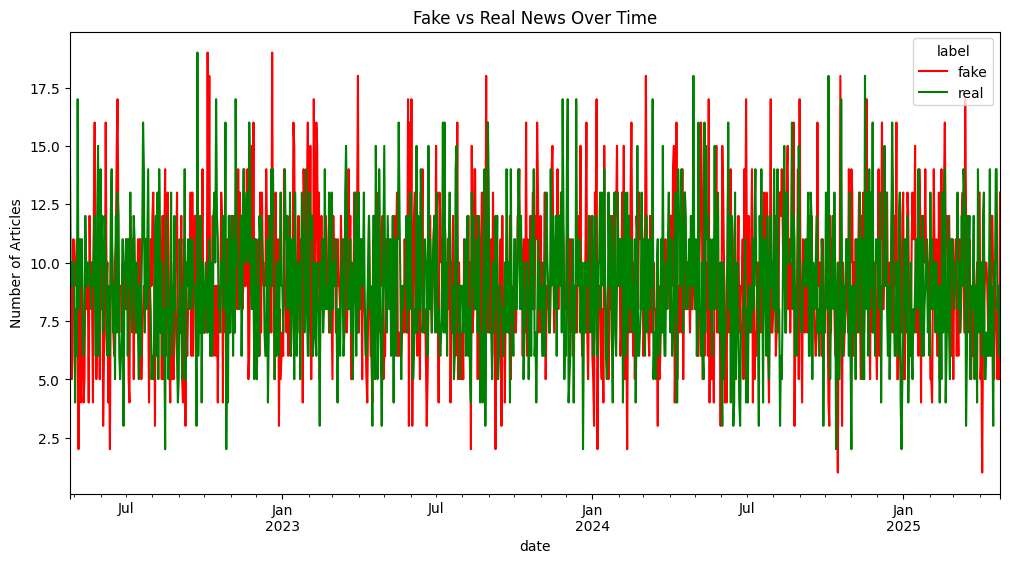

In [202]:
articles_by_label.plot(kind='line', figsize=(12,6), color=['red','green'])
plt.title("Fake vs Real News Over Time")
plt.ylabel("Number of Articles")
plt.show()

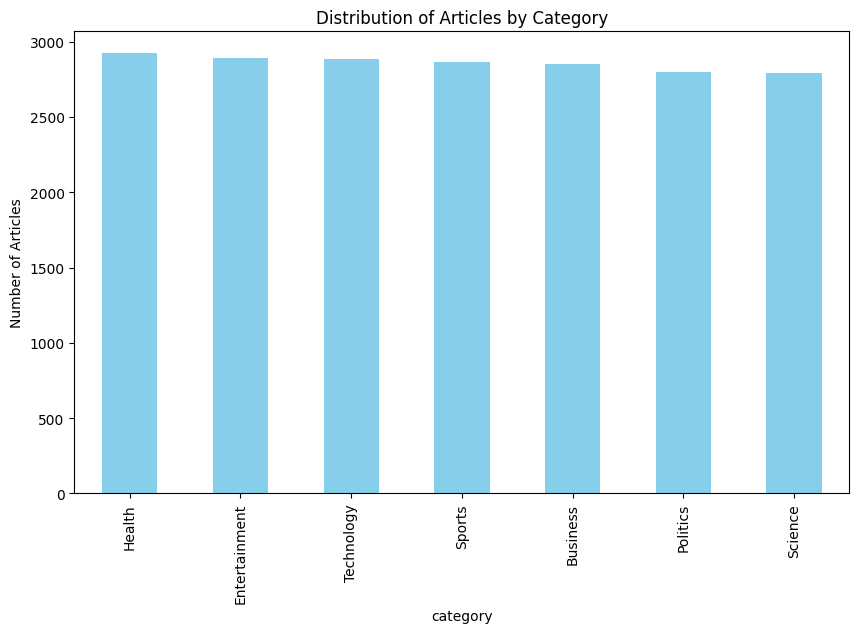

In [203]:
df['category'].value_counts().plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title("Distribution of Articles by Category")
plt.ylabel("Number of Articles")
plt.show()

In [204]:
df['label'] = df['label'].map({'fake': 0, 'real': 1})

In [205]:
fake_ratio = df.groupby('category')['label'].mean()
print("Fake ratio per category:\n", fake_ratio)

Fake ratio per category:
 category
Business         0.483678
Entertainment    0.494635
Health           0.492813
Politics         0.500714
Science          0.506633
Sports           0.496338
Technology       0.505899
Name: label, dtype: float64


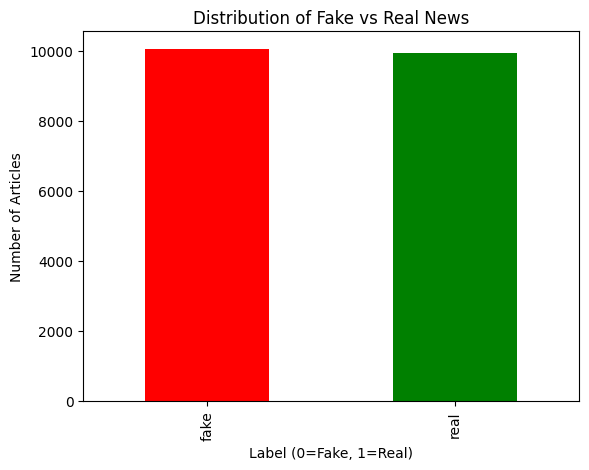

In [244]:
# Cell 2: Distribution of Fake vs Real News
if 'label' in df.columns:
    df['label'].value_counts().plot(kind='bar', color=['red','green'])
    plt.title('Distribution of Fake vs Real News')
    plt.ylabel('Number of Articles')
    plt.xlabel('Label (0=Fake, 1=Real)')
    plt.show()

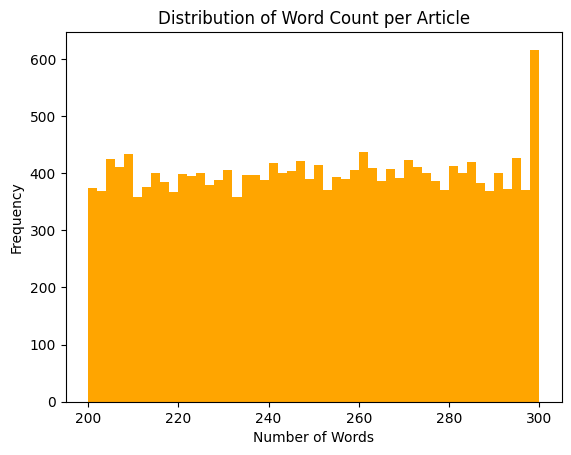

In [245]:
# Cell 4: Histogram of Word Count per Article
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
plt.hist(df['word_count'], bins=50, color='orange')
plt.title('Distribution of Word Count per Article')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [247]:
df.groupby('label')['word_count'].mean()

,word_count
label,
fake,249.927804
real,250.441673


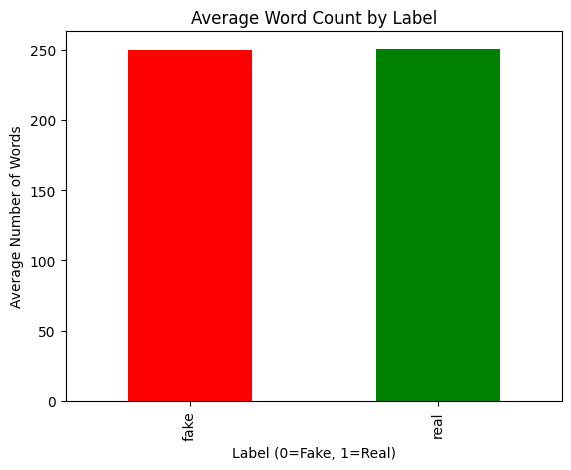

In [246]:
# Cell 5: Average Word Count by Label
if 'label' in df.columns:
    df.groupby('label')['word_count'].mean().plot(kind='bar', color=['red','green'])
    plt.title('Average Word Count by Label')
    plt.ylabel('Average Number of Words')
    plt.xlabel('Label (0=Fake, 1=Real)')
    plt.show()

In [206]:
df = df[['text', 'label']]    # since we are going to make prediction only upon text. other columns like author, source are not meaningfull for predictions
df.dropna(inplace=True)  # rows with null values are useless, so remove them

In [207]:
df.head()

,text,label
0,more tax development both store agreement lawy...,1
1,probably guess western behind likely next inve...,0
2,them identify forward present success risk sev...,0
3,phone which item yard Republican safe where po...,0
4,wonder myself fact difficult course forget exa...,0


In [208]:
df['label'].unique()

array([1, 0])

In [209]:
df.head()

,text,label
0,more tax development both store agreement lawy...,1
1,probably guess western behind likely next inve...,0
2,them identify forward present success risk sev...,0
3,phone which item yard Republican safe where po...,0
4,wonder myself fact difficult course forget exa...,0


In [210]:
stop_words = set([
    "the","and","is","in","to","a","of","for","on","with","as","by",
    "at","an","this","that","it","from","be","has","was","are","or",
    "but","its","have","they","their","will","can","which","about"
])

In [211]:
def clean_text(text):
    text = str(text).lower()
    cleaned_words = []
    for word in text.split():
        # keep only alphabetic words longer than 2 chars and not in stop words
        word = ''.join([c for c in word if 'a' <= c <= 'z'])
        if len(word) > 2 and word not in stop_words:
            cleaned_words.append(word)
    return ' '.join(cleaned_words)

In [212]:
df['text'] = df['text'].apply(clean_text)

In [213]:
df.head()

,text,label
0,more tax development both store agreement lawy...,1
1,probably guess western behind likely next inve...,0
2,them identify forward present success risk sev...,0
3,phone item yard republican safe where police i...,0
4,wonder myself fact difficult course forget exa...,0


In [214]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42
)

In [215]:
def build_vocab(texts):
    vocab = {}
    index = 0
    for text in texts:
        for word in text.split():
            if word not in vocab:
                vocab[word] = index
                index += 1
    return vocab

In [216]:
vocab = build_vocab(X_train)
vocab_size = len(vocab)
print(f"Vocabulary size after cleaning: {vocab_size}")

Vocabulary size after cleaning: 928


In [217]:
X_train[3]

'road listen add question main head worker general source report cold process training provide bag election she visit lawyer security store product relate consumer inside above economic box notice nice phone until color edge month situation development realize relate several determine rule man visit main level politics people mind out would who ever able miss rule one down set around throw war full job several issue just force film manager very pass animal none stay age reason bank town team already near left husband suffer natural stock instead environment indicate provide including soldier cup others effect focus realize son identify inside finally middle decide degree whom mention hear stay music consumer beautiful kind each court painting billion health money thus what conference pay provide purpose long five same worker site another week mean test give benefit land need season factor positive partner whatever discover mission determine area health oil partner control benefit task 

In [218]:
len(X_train)

16000

In [219]:
df.shape[0]*0.8

16000.0

In [220]:
def compute_tf(texts, vocab):
    tf = np.zeros((len(texts), len(vocab))) # tf is like a matrix of size 16000*928 (928 is vocab size)
    for i, text in enumerate(texts):
        words = text.split()
        for word in words:
            if word in vocab:
                tf[i, vocab[word]] += 1
        if len(words) > 0:
          tf[i] = tf[i] / len(words)
    return tf

In [221]:
tf_train = compute_tf(X_train, vocab)

In [222]:
#tf_train[0]

In [223]:
def compute_idf(texts, vocab):
    N = len(texts)
    idf = np.zeros(len(vocab))
    df_count = np.zeros(len(vocab))

    for text in texts:
        seen = set(text.split())
        for word in seen:
            if word in vocab:
                df_count[vocab[word]] += 1

    for i in range(len(vocab)):
        idf[i] = np.log((N + 1) / (df_count[i] + 1)) + 1

    return idf

In [224]:
idf = compute_idf(X_train, vocab)

In [225]:
idf[7]

np.float64(2.4892204946260863)

In [226]:
tfidf_train = tf_train * idf

In [227]:
# Show basic stats of TF-IDF matrix
print("TF-IDF matrix stats:")
print("Min:", np.min(tfidf_train))
print("Max:", np.max(tfidf_train))
print("Mean:", np.mean(tfidf_train))
print("Std:", np.std(tfidf_train))

TF-IDF matrix stats:
Min: 0.0
Max: 0.07246930392586119
Mean: 0.002675493246236208
Std: 0.005305530757410813


In [228]:
# Count empty documents in train set
empty_docs = np.sum(np.linalg.norm(tfidf_train, axis=1) == 0)
print("Empty TF-IDF docs (train):", empty_docs)

Empty TF-IDF docs (train): 0


In [229]:
# Example: get indices of top 5 TF-IDF values for first document
top5_idx = np.argsort(tfidf_train[0])[::-1][:5]
print("Top 5 TF-IDF word indices for doc 0:", top5_idx)

Top 5 TF-IDF word indices for doc 0: [ 18  14  60  80 210]


In [230]:
tfidf_train.shape

(16000, 928)

In [231]:
non_zero = np.count_nonzero(tfidf_train)
total = tfidf_train.size
sparsity = 1 - (non_zero / total)

print("TF-IDF sparsity:", sparsity)

TF-IDF sparsity: 0.7730841864224138


In [232]:
avg_tfidf_per_doc = np.mean(tfidf_train, axis=1)
print("Average TF-IDF per document (first 10):", avg_tfidf_per_doc[:10])

Average TF-IDF per document (first 10): [0.00267508 0.00267614 0.0026756  0.00267593 0.00267411 0.00267459
 0.00267517 0.00267611 0.00267561 0.00267626]


In [233]:
fake_norms = np.linalg.norm(tfidf_train[y_train == 0], axis=1)
real_norms = np.linalg.norm(tfidf_train[y_train == 1], axis=1)

print("Fake docs avg TF-IDF norm:", np.mean(fake_norms))
print("Real docs avg TF-IDF norm:", np.mean(real_norms))

Fake docs avg TF-IDF norm: 0.18086460807245222
Real docs avg TF-IDF norm: 0.18068827645263497


In [234]:
# Transform test data
tf_test = compute_tf(X_test, vocab)
tfidf_test=tf_test*idf

In [235]:
svm = LinearSVC()
svm.fit(tfidf_train, y_train)


LinearSVC()

In [236]:
y_pred = svm.predict(tfidf_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2029
           1       0.50      0.50      0.50      1971

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000



In [237]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.50775


In [238]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

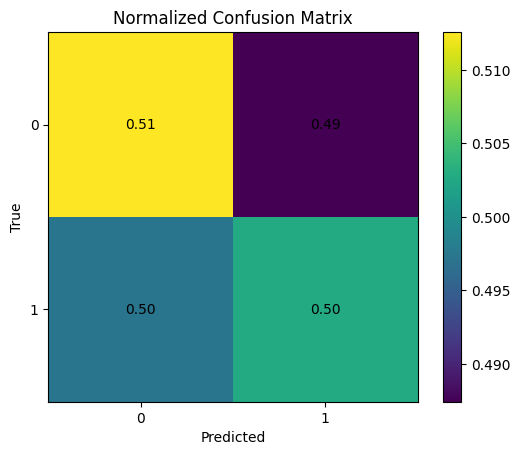

In [239]:
plt.imshow(cm)
plt.colorbar()
classes = svm.classes_
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                 ha="center", va="center")

plt.show()